# Predictions

I'll be using SARIMAX model to predict the sales for different time periods.
SARIMAX appears to be the most used model for time series (with seasonality) forecasting.

[Note: The data is clean, the only missing data (we know from the other notebook) is the postal code for a city. This will not be needed]

## 1. Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Usefull metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Some usefull functions defined in separate files
import sys

sys.path.append('..')
from utils import *
from plots import *

In [3]:
# Load data
data = pd.read_csv('train.csv')
data.drop('Row ID', axis=1, inplace=True)

# Convert date to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], dayfirst=True)
data['Ship Date'] = pd.to_datetime(data['Ship Date'], dayfirst=True)

# Sort and index by date
data.sort_values('Order Date', inplace=True, ascending=True)
data.set_index('Order Date', inplace=True)

In [4]:
# Extract useful features
df = pd.DataFrame(data['Sales'])
df = df.resample('D').sum()
df = df.interpolate(method='linear')

# Train test split
end = 10
train_data = df.iloc[:-end]

## 2. Visualizations

Text(0.5, 1.0, 'Lag plot of sales')

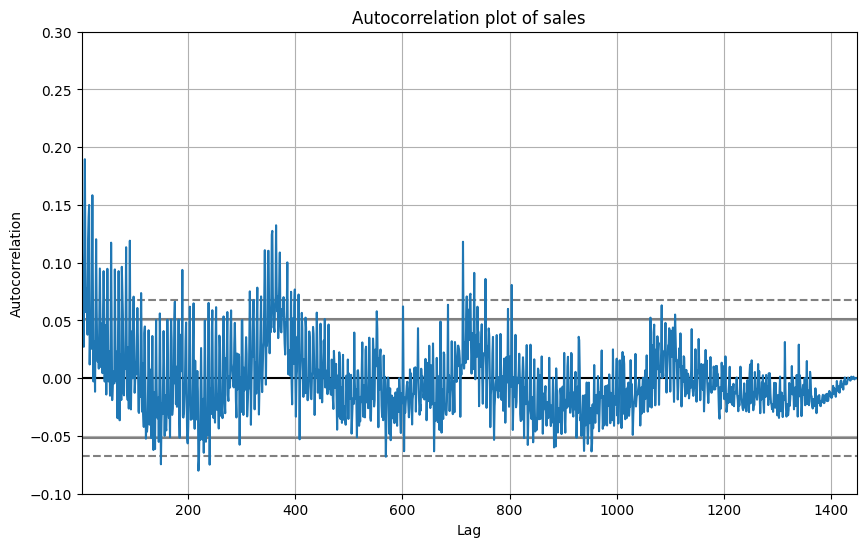

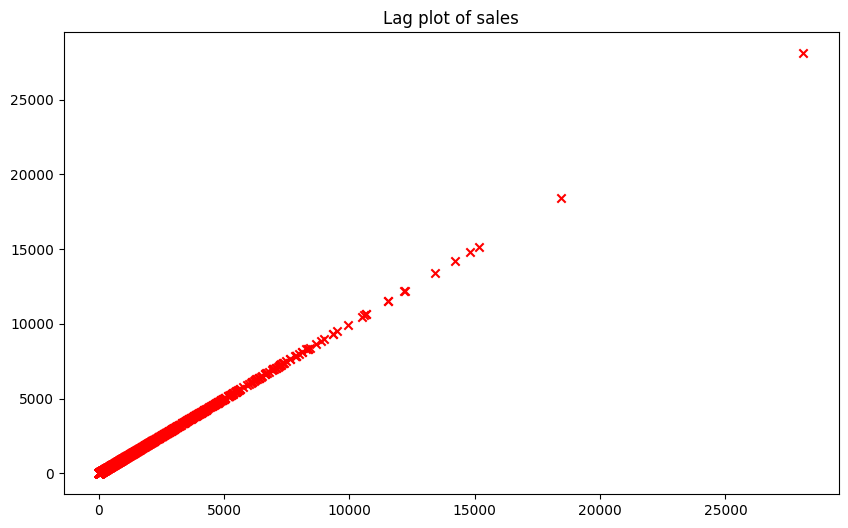

In [5]:
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(train_data['Sales'])
plt.title('Autocorrelation plot of sales')
plt.ylim(-0.1, 0.3)

plt.figure(figsize=(10, 6))
plt.scatter(train_data['Sales'].shift(1, freq="infer"), train_data['Sales'], marker='x', color='red')
plt.title('Lag plot of sales')

In [6]:
# Augmented Dicky Fuller Test

# Definition of the test:
# Null Hypothesis (H0): Time series is not stationary
# Alternative Hypothesis (H1): Time series is stationary



adf_test = adfuller(train_data['Sales']) 


print('Augmented Dicky Fuller Test Results: ')
print('-----------------------------------')
print(f'\nADF Statistic: {adf_test[0]}')
print(f'\np-value: {adf_test[1]}')
print('\nCritical Values: ')

#Print p-value (1%, 5% and 10%) and respective values
for per, val in adf_test[4].items(): 
    print(per,':',val)
    
    if adf_test[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')

Augmented Dicky Fuller Test Results: 
-----------------------------------

ADF Statistic: -4.932402877914659

p-value: 3.014819111696865e-05

Critical Values: 
1% : -3.4349408214067227
Null Hypothesis Rejected. Time Series is Stationary
5% : -2.8635675309927153
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.5678494453155656
Null Hypothesis Rejected. Time Series is Stationary


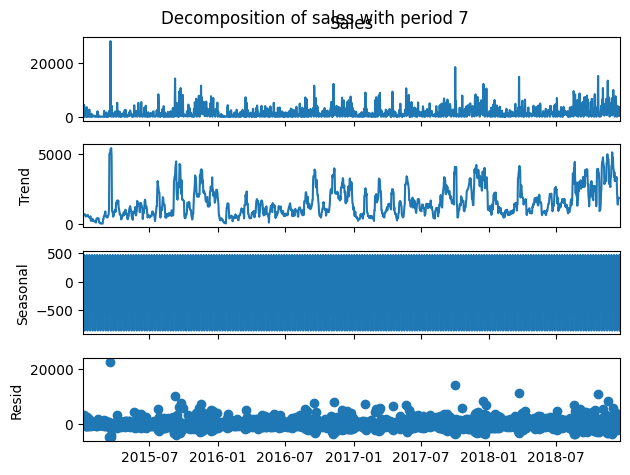

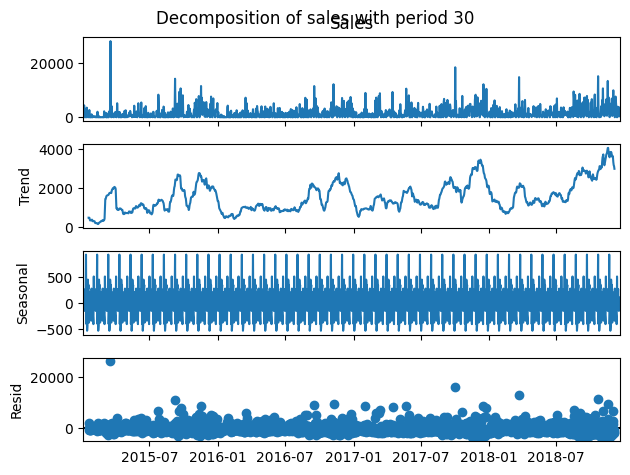

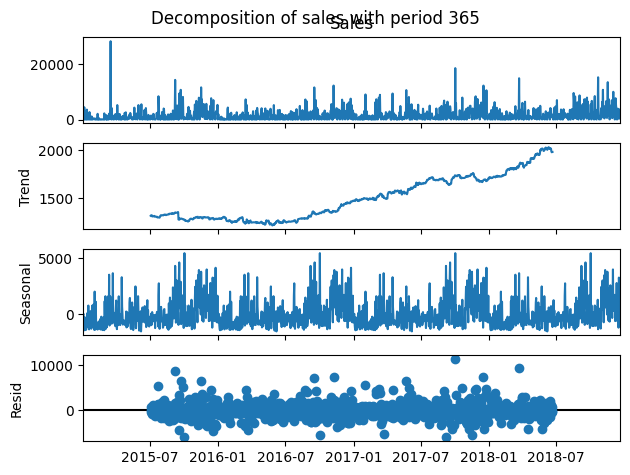

In [7]:
# Decompose data by seasonality with periods (7, 30 and 365)
decomp_7 = seasonal_decompose(train_data['Sales'], model='additive', period=7)
decomp_30 = seasonal_decompose(train_data['Sales'], model='additive', period=30)
decomp_365 = seasonal_decompose(train_data['Sales'], model='additive', period=365)

# Plot decompositions
decomp_7.plot()
plt.suptitle('Decomposition of sales with period 7')
plt.show()

decomp_30.plot()
plt.suptitle('Decomposition of sales with period 30')
plt.show()

decomp_365.plot()
plt.suptitle('Decomposition of sales with period 365')
plt.show()

In [14]:
sarimax_params = (5, 1, 0)
seasonal_params = (1, 1, 0, 12)

In [9]:
sarimax_model = SARIMAX(
	train_data['Sales'],
	order=sarimax_params, 
	seasonal_order=seasonal_params, 
	enforce_stationarity=False, 
	enforce_invertibility=False,
	trend='c'
	)
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                 1448
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 12)   Log Likelihood              -13315.833
Date:                            Fri, 28 Jun 2024   AIC                          26647.666
Time:                                    22:51:01   BIC                          26689.722
Sample:                                01-03-2015   HQIC                         26663.377
                                     - 12-20-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.4810    109.234     -0.041      0.967    -218.575     209.613
ar.L1         -0.7424      0.028   

Residual bins: [ 1  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  1  0  0  0  0  0
  0  1  0  0  0  1  2  0  4  1  0  2  1  3  3  3  1  3  4  4  7  3  9  5
  7 12  9 14 17 13 16 16 17 30 27 37 40 34 43 45 53 50 61 66 82 74 65 50
 53 52 42 36 31 27 27 24 17 18 16 16 16 16 16  5  9  9 10  8  8  2  6  2
  3  1  4  0  5  2  1  7  1  1  0  1  1  3  0  1  2  0  0  0  2  0  2  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  1  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1]

Residuals mean: 0   -0.234406
dtype: float64
Residuals true mean: 0   -43.445533
dtype: float64
Residuals stdev: 0    2815.234678
dtype: float64
Residuals skew: 0    1.060852
dtype: float64
Residuals normality: 0    9.320646
dtype: float64


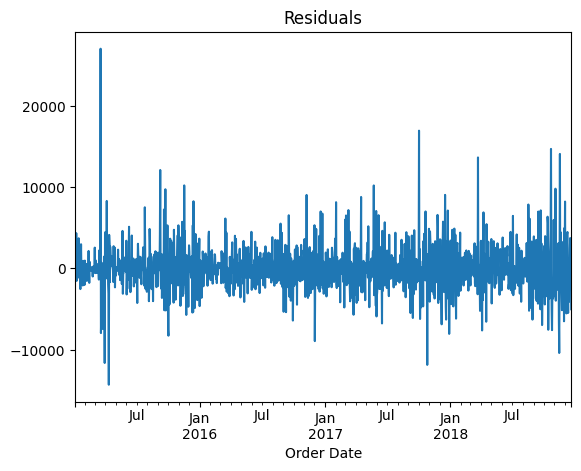

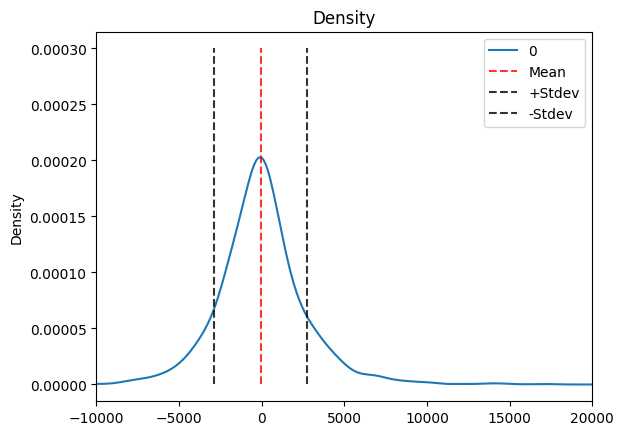

In [10]:
residuals = pd.DataFrame(sarimax_fit.resid)

# Define the number of bins
num_bins = 200

# Calculate the histogram of residuals
residuals_bins, bin_edges = np.histogram(residuals, bins=num_bins)

# Print the histogram bins
print(f"Residual bins: {residuals_bins}\n")
max_bin_index = np.argmax(residuals_bins)
max_bin_edges = bin_edges[max_bin_index:max_bin_index+2]

# Plots
residuals.plot(legend=False, title='Residuals')

residuals.plot(kind='density', title='Density', legend=False)


plt.xlim(-10000, 20000)
plt.vlines(residuals.mean()+max_bin_edges[1], 0, 0.0003, colors='red', linestyles='dashed', alpha=0.8, label='Mean')
plt.vlines(residuals.std()+max_bin_edges[1], 0, 0.0003, colors='black', linestyles='dashed', alpha=0.8, label='+Stdev')
plt.vlines(-residuals.std()+max_bin_edges[1], 0, 0.0003, colors='black', linestyles='dashed', alpha=0.8, label='-Stdev')

plt.legend()


# Print the residuals statistics
print(f"Residuals mean: {residuals.mean()}")
print(f"Residuals true mean: {residuals.mean()+max_bin_edges[1]}")
print(f"Residuals stdev: {residuals.std()}")
print(f"Residuals skew: {residuals.skew()}")
print(f"Residuals normality: {residuals.kurtosis()}")

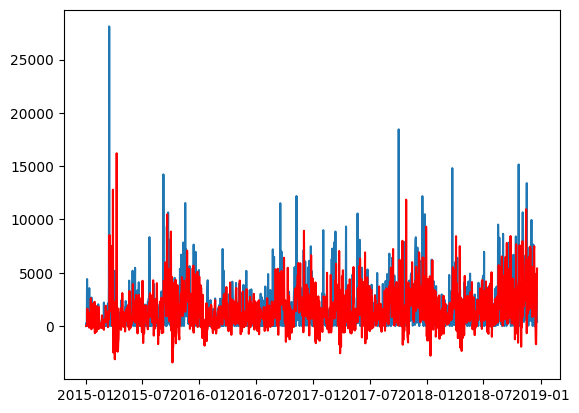

In [11]:
plt.figure()
plt.plot(train_data['Sales'], label='Actual')
plt.plot(sarimax_fit.get_prediction().predicted_mean, color='red', label='Predicted')

(array([17886., 17887., 17888., 17889., 17890., 17891., 17892., 17893.,
        17894., 17895.]),
 [Text(17886.0, 0, '2018-12-21'),
  Text(17887.0, 0, '2018-12-22'),
  Text(17888.0, 0, '2018-12-23'),
  Text(17889.0, 0, '2018-12-24'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17891.0, 0, '2018-12-26'),
  Text(17892.0, 0, '2018-12-27'),
  Text(17893.0, 0, '2018-12-28'),
  Text(17894.0, 0, '2018-12-29'),
  Text(17895.0, 0, '2018-12-30')])

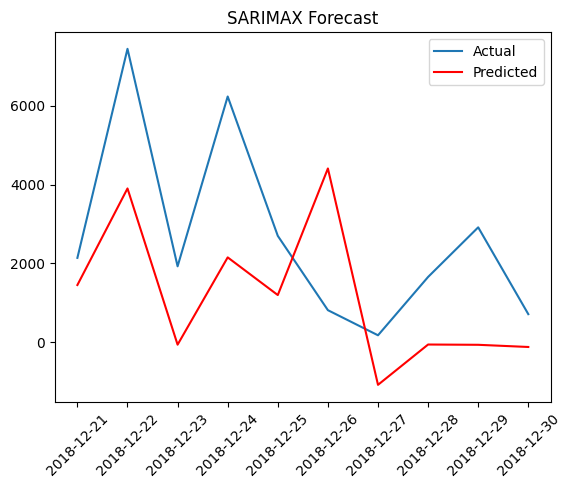

In [12]:
# Predict next 7 days
steps = end
forecast = sarimax_fit.get_forecast(steps=steps)
forecast_dates = pd.date_range(start=df.index[-steps], periods=steps, freq='D')
forecast = pd.DataFrame(forecast.predicted_mean.values, index=forecast_dates)
forecast.columns = ['Sales']

plt.figure()
plt.plot(df['Sales'].iloc[-end:], label='Actual')
plt.plot(forecast['Sales'], color='red', label='Predicted')

plt.title('SARIMAX Forecast')
plt.legend()
plt.xticks(rotation=45)


In [15]:
alt_params = (1, 1, 1)
alt_seasonal_params = (1, 1, 1, 12)

In [16]:
alt_model = SARIMAX(
	train_data['Sales'],
	order=alt_params, 
	seasonal_order=alt_seasonal_params, 
	enforce_stationarity=False, 
	enforce_invertibility=False,
	trend='c'
	)
alt_model_fit = alt_model.fit()
print(alt_model_fit.summary())

c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                 1448
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -13025.865
Date:                            Fri, 28 Jun 2024   AIC                          26063.730
Time:                                    22:58:16   BIC                          26095.285
Sample:                                01-03-2015   HQIC                         26075.518
                                     - 12-20-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.6722      1.975      4.391      0.000       4.802      12.543
ar.L1         -0.0131      0.029   

Residual bins: [ 2  1  1  0  4  2  5  2  7  7  6 19 23 13 18 17 19 23 34 42 31 64 48 67
 74 71 64 80 65 62 54 49 56 42 35 31 26 28 19 25 10 11 14 11 14 14 14 14
  9  4  7  5  3  6  6  6  5  4  5  3  5  2  1  2  0  4  2  4  1  1  0  5
  1  0  0  0  1  2  2  0  1  0  0  0  1  1  1  0  0  2  0  0  0  1  1  0
  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1]

Residuals mean: 0   -418.852937
dtype: float64
Residuals true mean: 0   -1171.158321
dtype: float64
Residuals stdev: 0    2263.384393
dtype: float64
Residuals skew: 0    2.884579
dtype: float64
Residuals normality: 0    20.836966
dtype: float64


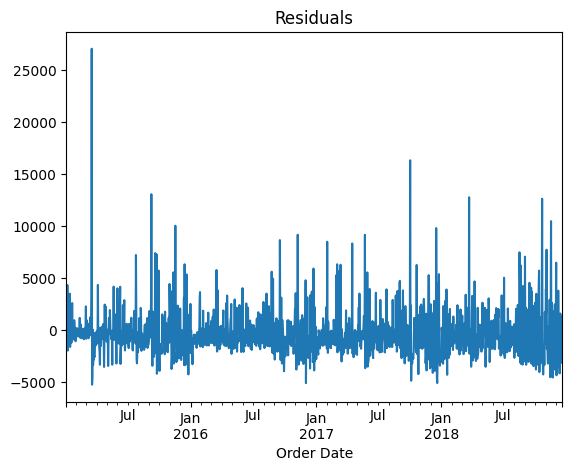

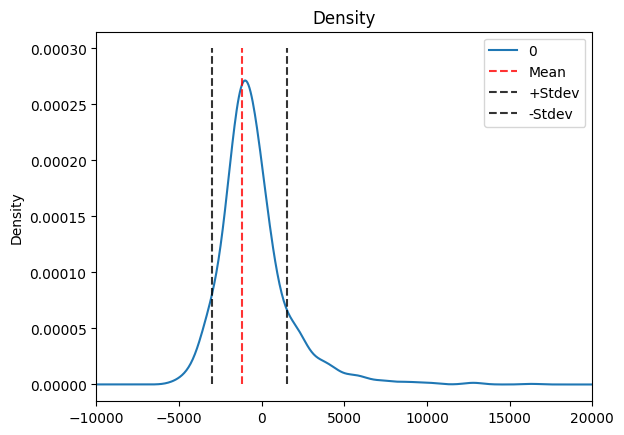

In [17]:
alt_residuals = pd.DataFrame(alt_model_fit.resid)

# Define the number of bins
num_bins_alt = 200

# Calculate the histogram of residuals
residuals_bins_alt, bin_edges_alt = np.histogram(alt_residuals, bins=num_bins_alt)

# Print the histogram bins
print(f"Residual bins: {residuals_bins_alt}\n")
max_bin_index_alt = np.argmax(residuals_bins_alt)
max_bin_edges_alt = bin_edges_alt[max_bin_index_alt:max_bin_index_alt+2]

# Plots
alt_residuals.plot(legend=False, title='Residuals')

alt_residuals.plot(kind='density', title='Density', legend=False)


plt.xlim(-10000, 20000)
plt.vlines(alt_residuals.mean()+max_bin_edges_alt[1], 0, 0.0003, colors='red', linestyles='dashed', alpha=0.8, label='Mean')
plt.vlines(alt_residuals.std()+max_bin_edges_alt[1], 0, 0.0003, colors='black', linestyles='dashed', alpha=0.8, label='+Stdev')
plt.vlines(-alt_residuals.std()+max_bin_edges_alt[1], 0, 0.0003, colors='black', linestyles='dashed', alpha=0.8, label='-Stdev')

plt.legend()


# Print the residuals statistics
print(f"Residuals mean: {alt_residuals.mean()}")
print(f"Residuals true mean: {alt_residuals.mean()+max_bin_edges_alt[1]}")
print(f"Residuals stdev: {alt_residuals.std()}")
print(f"Residuals skew: {alt_residuals.skew()}")
print(f"Residuals normality: {alt_residuals.kurtosis()}")

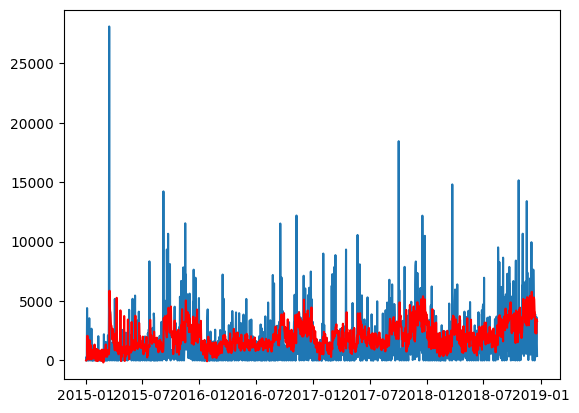

In [18]:
plt.figure()
plt.plot(train_data['Sales'], label='Actual')
plt.plot(alt_model_fit.get_prediction().predicted_mean, color='red', label='Predicted')

(array([17886., 17887., 17888., 17889., 17890., 17891., 17892., 17893.,
        17894., 17895.]),
 [Text(17886.0, 0, '2018-12-21'),
  Text(17887.0, 0, '2018-12-22'),
  Text(17888.0, 0, '2018-12-23'),
  Text(17889.0, 0, '2018-12-24'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17891.0, 0, '2018-12-26'),
  Text(17892.0, 0, '2018-12-27'),
  Text(17893.0, 0, '2018-12-28'),
  Text(17894.0, 0, '2018-12-29'),
  Text(17895.0, 0, '2018-12-30')])

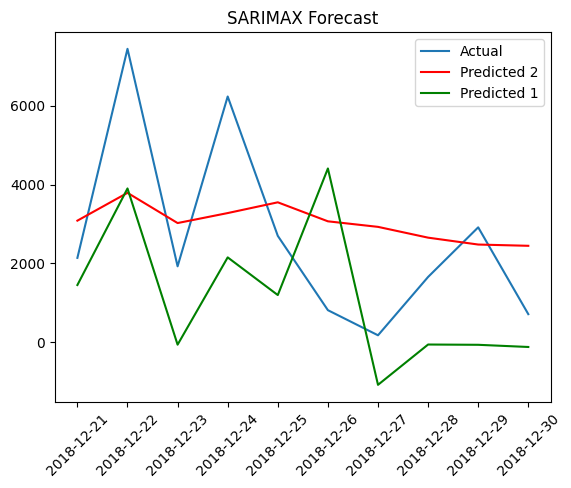

In [20]:
# Predict next 7 days
steps = end
forecast_alt = alt_model_fit.get_forecast(steps=steps)
forecast_dates = pd.date_range(start=df.index[-steps], periods=steps, freq='D')
forecast_alt = pd.DataFrame(forecast_alt.predicted_mean.values, index=forecast_dates)
forecast_alt.columns = ['Sales']

plt.figure()
plt.plot(df['Sales'].iloc[-end:], label='Actual')
plt.plot(forecast_alt['Sales'], color='red', label='Predicted 2')
plt.plot(forecast['Sales'], color='green', label='Predicted 1')

plt.title('SARIMAX Forecast')
plt.legend()
plt.xticks(rotation=45)


In [21]:
# First parameters are better